Vamos entrenar sistemas de clasificación de texto con BoW/TF-IDF + Reg. Logística poniendo especial énfasis en los pasos más importantes que tenemos que seguir para resolver tareas de clasificación con Machine Learning.

In [2]:
%%capture
!pip install watermark datasets

In [3]:
%load_ext watermark

In [4]:
%watermark -udvp numpy,pandas,datasets,sklearn

Last updated: 2024-02-15

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy   : 1.25.2
pandas  : 1.5.3
datasets: 2.17.0
sklearn : 1.2.2



### Datos

**IMPORTANTE** para el TP

* Siempre investigar acerca del dataset antes de explorarlo (e.g. leer repositorios o papers asociados, etc.)

In [8]:
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "emotion")

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

**IMPORTANTE**

* Siempre explorar los datos para saber qué problemas puede haber (e.g. datos faltantes, labels inesperados en alguna partición del dataset, documentos muy largos, caracteres raros en el input, etc.)

In [10]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)}

In [11]:
dataset["train"][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

In [12]:
# Convertimos los labels a strings por comodidad
int2label = dataset["train"].features["label"].int2str
dataset = dataset.map(lambda example: {"label_str": int2label(example["label"])}, remove_columns=["label"])
dataset = dataset.rename_column("label_str", "label")

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

In [13]:
dataset["train"][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 'optimism'}

In [14]:
# Convertimos a pandas por comodidad
import pandas as pd
pd.options.display.max_colwidth = 300

df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()
df_test = dataset["test"].to_pandas()
#del dataset

In [15]:
df_train.sample(10)

,text,label
157,Why is it so windy? So glad I didn't ride my bike. #fear #wind,joy
926,You don't know what to expect by Brendon's video lmao LA devotee video got me shook,joy
1441,If you really care like you state @user @user then I would seriously address sensitivity training to your employees #awful,anger
3090,@user I can't get a better look at her bc I'm too shy to make eye contact ;-;,sadness
1071,I like cycling because I get to intimidate people with my powerful calves &amp; horrendous tan lines.,joy
1637,"@user This would be the height of hilarity, were it not for the fact that the adult swan is highly likely to attack.",joy
2429,"Lament a \nsaddened heart,\nso far &amp; \nyet so near,\nthe years so\ntough &amp; scarred,\nthis lonesome\nroad,\nstill feared! #depression \n\n#poetry #poem",sadness
967,@user #dobetter only two carriages on 14:49 Birmingham to Hereford no room to stand anymore Friday commute #unhappy,sadness
1581,"@user Eric couldn't help but laugh, though that made him wince in pain. It hurt. A lot. He just wanted to sit down somewhere —",sadness
2017,Throwback to when Khloe Kardashian was a host on The X Factor and she was fucking terrible at it,anger


In [16]:
for df in [df_train, df_val, df_test]:
    print(df["label"].value_counts(normalize=False))
    print()

anger       1400
sadness      855
joy          708
optimism     294
Name: label, dtype: int64

anger       160
joy          97
sadness      89
optimism     28
Name: label, dtype: int64

anger       558
sadness     382
joy         358
optimism    123
Name: label, dtype: int64



**IMPORTANTE**

* El preprocesamiento del texto (las transformaciones que hagamos antes de correr modelos) depende del dominio de los datos, de las características del dataset particular, de los modelos vayamos a usar, de la tarea que queremos resolver, etc.
* Muchas veces lo mejor es evaluar si algún paso de preprocesamiento altera el rendimiento del modelo antes de aplicarlo, como vamos a ver más adelante

In [17]:
# Vamos a hacer algo sencillo A MODO DE EJEMPLO.
# Convertimos 3 o mas letras repetidas a 3 letras: "hellooooo" -> "hellooo"
import re

re.sub(r"(\w)\1{2,}", r"\1\1\1", "hellooooo is anyboooody theere?")

'hellooo is anybooody theere?'

In [18]:
def preprocess_text(text):
    # Qué otros pasos de preprocesamiento pueden servir en este problema?
    text = re.sub(r"(\w)\1{2,}", r"\1\1\1", text)
    text = text.strip()
    return text

In [19]:
preprocess_text("hellooooo is anyboooody theere?")

'hellooo is anybooody theere?'

In [20]:
for df in [df_train, df_val, df_test]:
    df["text"] = df["text"].apply(preprocess_text)

### Estrategia de evaluación

**IMPORTANTE**:

* Antes de definir qué modelos queremos probar y qué hiperparámetros queremos tunear, debemos definir cómo vamos a evaluar los modelos. En particular:

1. Métrica de evaluación
   * Tenemos un dataset de clasificación multiclase desbalanceado donde ninguna clase parece ser más importante que el resto --> qué métrica podemos usar?
2. Partición de datos (e.g. un único test set, holdout aka validation aka dev set, cross-validation)
   * El dataset ya viene con una partición train/dev/test --> Para qué sirve cada partición? Por qué no alcanzaría con un único test set? En qué escenarios alcanza con un único test set? Por qué es tan importante un test set completamente aislado? Cuándo conviene usar cross-validation?

### Modelos

**IMPORTANTE**:

* El _modelo_ no es solo el clasificador que corremos sobre los features, sino también la manera en la que generamos los features!
* Tenemos que entender qué hacen los modelos que vamos a probar, qué hiperparámetros tienen y qué hace cada uno.

In [21]:
# Veamos cómo funciona BoW con CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()

textos = [
    "Qué rico que es el mate",
    "el mate es muy... rico",
    "el mate es rico?",
]
# Aprende el vocabulario:
bow.fit(textos)

CountVectorizer()

In [22]:
# Implícitamente hizo un preprocesamiento
print(bow.vocabulary_)

{'qué': 5, 'rico': 6, 'que': 4, 'es': 1, 'el': 0, 'mate': 2, 'muy': 3}


In [23]:
# Para cada documento, contamos cuántas veces aparece cada palabra del vocabulario:
print(bow.transform(textos).toarray()) # transformamos cada doc en un vector de dimension fija
print(bow.get_feature_names_out())

[[1 1 1 0 1 1 1]
 [1 1 1 1 0 0 1]
 [1 1 1 0 0 0 1]]
['el' 'es' 'mate' 'muy' 'que' 'qué' 'rico']


In [24]:
# Como DataFrame:
df_tmp = pd.DataFrame(bow.transform(textos).toarray(), columns=bow.get_feature_names_out())
df_tmp

,el,es,mate,muy,que,qué,rico
0,1,1,1,0,1,1,1
1,1,1,1,1,0,0,1
2,1,1,1,0,0,0,1


In [25]:
# Y si lo aplicamos a textos que no estaban en el entrenamiento?
textos_test = [
    "el mate es una bebida muy muy rica",
    "Aguante Boca",
    "Qué rico que es el té!!!",
]
df_tmp = pd.DataFrame(bow.transform(textos_test).toarray(), columns=bow.get_feature_names_out())
df_tmp

,el,es,mate,muy,que,qué,rico
0,1,1,1,2,0,0,0
1,0,0,0,0,0,0,0
2,1,1,0,0,1,1,1


**IMPORTANTE**:

* Tener control de lo que estamos haciendo, es decir, entender exactamente cómo estamos representando los documentos. En este caso:
  * Qué estamos haciendo con las palabras OOV?
  * Qué estamos haciendo con la puntuación?
  * Con las mayúsculas?
  * Las palabras repetidas?
  * etc.

In [26]:
# Corramos una version preliminar de un clasificador con BoW features:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score

vectorizer = CountVectorizer(max_features=5_000)
classifier = LogisticRegression(max_iter=1000, random_state=33)

vectorizer.fit(df_train["text"]) # Aprende el vocabulario
X_train = vectorizer.transform(df_train["text"]) # Transforma los textos en vectores
# equivalente:
# X_train = vectorizer.fit_transform(df_train["text"])

y_train = df_train["label"]
classifier.fit(X_train, y_train) # Entrena el clasificador


LogisticRegression(max_iter=1000, random_state=33)

In [27]:
# Evaluamos en el conjunto de validación:
X_val = vectorizer.transform(df_val["text"])
y_val = df_val["label"]
y_pred = classifier.predict(X_val) # Qué estamos haciendo cuando corremos predict?
# NOTE la rpta es argmax de las probas -- equivale a umbral 0.5 en el caso binario
print(fbeta_score(y_val, y_pred, beta=1, average="macro"))

0.5707677715408208


In [28]:
# Con otros parametros:
vectorizer = CountVectorizer(stop_words="english", min_df=5)
classifier = LogisticRegression(max_iter=1000, random_state=33)

X_train = vectorizer.fit_transform(df_train["text"])
_ = classifier.fit(X_train, y_train)
X_val = vectorizer.transform(df_val["text"])
y_pred = classifier.predict(X_val)
print(fbeta_score(y_val, y_pred, beta=1, average="macro"))

0.5525800834790806


In [29]:
# Y si usamos TF-IDF? Por qué podría ser mejor?
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5_000)
classifier = LogisticRegression(max_iter=1000, random_state=33)

X_train = vectorizer.fit_transform(df_train["text"])
print(vectorizer.idf_) # idf de cada palabra
print(vectorizer.get_feature_names_out()) # vocabulario

[8.39572161 7.9902565  6.25565545 ... 8.39572161 8.39572161 8.39572161]
['00pm' '08' '10' ... 'zoolander' 'óg' 'الخفجي']


In [30]:
_ = classifier.fit(X_train, y_train)
X_val = vectorizer.transform(df_val["text"])
y_pred = classifier.predict(X_val)
print(fbeta_score(y_val, y_pred, beta=1, average="macro"))

0.5513608013608013


**IMPORTANTE**:

* Cómo sabemos si el rendimiento es bueno? Estamos ganando algo con Machine Learning? --> para saberlo tenemos que comparar con un baseline!
* El baseline puede ser un modelo ingenuo que siempre predice la clase mayoritaria, predecir aleatoriamente, o algo basado en reglas de negocio, expresiones regulares, etc -- depende del caso


In [31]:
# vamos usar un "dummy classifier" que predice segun las priors de entrenamiento
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy="prior")
_ = clf_dummy.fit(X_train, y_train)
y_pred = clf_dummy.predict(X_val)
print(fbeta_score(y_val, y_pred, beta=1, average="macro"))

# Con prediccion random?
clf_dummy = DummyClassifier(strategy="uniform")
_ = clf_dummy.fit(X_train, y_train)
y_pred = clf_dummy.predict(X_val)
print(fbeta_score(y_val, y_pred, beta=1, average="macro"))

0.149812734082397
0.22904654496389998


#### Selección de modelos

**IMPORTANTE**:

* En general un modelo no es UN modelo, sino un montón de configuraciones posibles. ¿Qué cosas podemos variar en este caso?
  * stopwords (param `stop_words`)
  * binary features (param `binary`)
  * tokenización (param `tokenizer`, `nltk.tokenize.TweetTokenizer`, ...)
  * usar ngramas como tokens (param `ngram_range`)
  * preprocesamiento (param `preprocessor`: lowercase, stemming con `nltk.stem.SnowballStemmer`, eliminar palabras muy o poco frecuentes con `min_df` y `max_df`, etc.)
  * propagación de negaciones (https://arxiv.org/ftp/arxiv/papers/1305/1305.6143.pdf section 5)
  * features adicionales (e.g. conteo de palabras positivas/negativas, conteo de OOV words, ... usar la imaginacion!)
  * Hiperparámetros del clasificador (e.g. regularizacion)
  * **etc etc etc**

* Antes de ponerse a correr código, definir qué pruebas quiero hacer y a qué tipo de resultado quiero llegar (un número? una tabla? un gráfico?)

In [32]:
# para hacer seleccion de modelos de manera prolija podemos usar pipelines de sklearn
# (tambien lo podemos programar a mano, claro!)
from sklearn.pipeline import Pipeline

# Estos pasos se van a aplicar secuencialmente al input
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(max_features=5_000)),
    ("classifier", LogisticRegression(max_iter=1000, random_state=33)),
])

_ = pipe.fit(df_train["text"], y_train) # Ajusta todos los pasos
y_pred = pipe.predict(df_val["text"]) # Transforma y predice
print(fbeta_score(y_val, y_pred, beta=1, average="macro"))

# Para usar CV en lugar de val set, podemos usar cross_val_score:
# cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')

0.5513608013608013


In [33]:
# A MODO ILUSTRATIVO, supongamos que nos interesa validar la eliminacion de
# stopwords, el uso de bigramas, y el uso de tf-idf:

# 1ro definimos un pipeline "esqueleto" con los pasos que queremos probar:
pipe = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression(max_iter=1000, random_state=33)),
])

In [34]:
# 2do definimos el espacio de modelos que queremos explorar con una "grilla":
param_grid = {
    "vectorizer": [CountVectorizer(), TfidfVectorizer()],
    "vectorizer__stop_words": [None, "english"],
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    # "vectorizer__tokenizer": [...],
}
# Hay un total de 2*2*2 = 8 modelos a probar
# Podemos separar pruebas usando una lista de diccionarios

In [35]:
# 3ro entrenamos todas las configuraciones posibles en train y evaluamos cada una en val:
# (usamos PredefinedSplit para que el conjunto de validacion sea siempre el mismo en GridSearchCV)
from sklearn.model_selection import GridSearchCV, PredefinedSplit

X = pd.concat([df_train, df_val]).reset_index(drop=True)["text"]
y = pd.concat([df_train, df_val]).reset_index(drop=True)["label"]
val_fold = [-1]*len(df_train) + [0]*len(df_val)
ps = PredefinedSplit(val_fold)
grid_search = GridSearchCV(
    pipe, param_grid, cv=ps, scoring="f1_macro", refit=False, verbose=10)

# Si hay demasiadas configuraciones posibes, podemos usar RandomizedSearchCV

In [36]:
_ = grid_search.fit(X, y)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV 1/1; 1/8] START vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None
[CV 1/1; 1/8] END vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None;, score=0.577 total time=   1.6s
[CV 1/1; 2/8] START vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english
[CV 1/1; 2/8] END vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english;, score=0.575 total time=   1.6s
[CV 1/1; 3/8] START vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None
[CV 1/1; 3/8] END vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None;, score=0.577 total time=   8.6s
[CV 1/1; 4/8] START vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english
[CV 1/1; 4/8] END vectorizer=CountVectorizer(), vectorizer__ngram_ran

In [37]:
df_results = pd.DataFrame(grid_search.cv_results_)
df_results.sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer,param_vectorizer__ngram_range,param_vectorizer__stop_words,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
2,8.53201,0.0,0.085312,0.0,CountVectorizer(),"(1, 2)",None,"{'vectorizer': CountVectorizer(), 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}",0.577169,0.577169,0.0,1


In [38]:
df_results.sort_values("rank_test_score").tail(1)
# El tuneo de HPs puede ser fundamental!!!

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer,param_vectorizer__ngram_range,param_vectorizer__stop_words,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
6,6.26628,0.0,0.046304,0.0,TfidfVectorizer(),"(1, 2)",None,"{'vectorizer': TfidfVectorizer(), 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}",0.429445,0.429445,0.0,8


### Análisis de resultados

**IMPORTANTE**:

* Muchas veces no solo importa el rendimiento del modelo, sino también entender qué está haciendo. Por ejemplo:
  * Feature importance: A qué features le da importancia el modelo? Tiene sentido?
  * Análisis de errores: en qué casos falla? qué tipos de errores comete? Puede ser muy útil primero correr un modelo sencillo y analizar los errores que comete, para tener una idea de por dónde conviene seguir trabajando.
  * Usar la imaginación!

* A la hora de analizar y presentar métricas, poner el foco en las que nos importan -- no mostrar todos los números porque sí

In [39]:
from sklearn.base import clone

best_pipe = clone(pipe)
best_pipe = best_pipe.set_params(**grid_search.best_params_)

In [40]:
best_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=33))])

              precision    recall  f1-score   support

       anger       0.66      0.83      0.74       160
         joy       0.70      0.53      0.60        97
    optimism       0.47      0.29      0.36        28
     sadness       0.64      0.60      0.62        89

    accuracy                           0.66       374
   macro avg       0.62      0.56      0.58       374
weighted avg       0.65      0.66      0.64       374



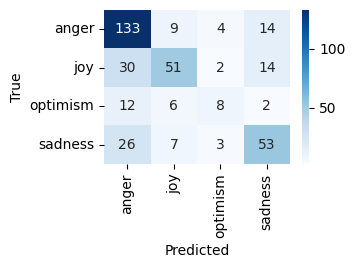

In [41]:
# analisis de metricas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

_ = best_pipe.fit(df_train["text"], df_train["label"])
y_pred = best_pipe.predict(df_val["text"])

print(classification_report(df_val["label"], y_pred))

cm = confusion_matrix(df_val["label"], y_pred)
plt.figure(figsize=(3,2))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=best_pipe.classes_, yticklabels=best_pipe.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [42]:
# analisis de errores:
df_val["proba_pred"] = best_pipe.predict_proba(df_val["text"]).max(axis=1)
df_val["pred"] = y_pred
df_val["correct"] = df_val["label"] == df_val["pred"]

# Top 5 errores:
df_val[~df_val["correct"]].sort_values("proba_pred", ascending=False).head(5)

,text,label,proba_pred,pred,correct
201,My new favourite #film with out a shadow of a doubt it #Okja #beautifull #funny #sad #emotional #real #Netflix #MUSTWATCH #now,joy,0.983135,sadness,False
325,@user @user can i ask im trying to pout a code on csgo roll i cant when i pout the code its red color.. help pls,sadness,0.934510,anger,False
92,@user You'll pine for my love one day Crabbe,sadness,0.921243,joy,False
334,I need to study up on celebrities' birthdays bc my heart almost stopped when I saw Harrison Ford trending... 😯 #relieved,joy,0.904900,sadness,False
293,"So me and my mom were talking about highschool, I'm shy so she said that she thinks I'm gonna get bullied😒 #shy #me #mylife #moms #bullying",anger,0.894042,sadness,False


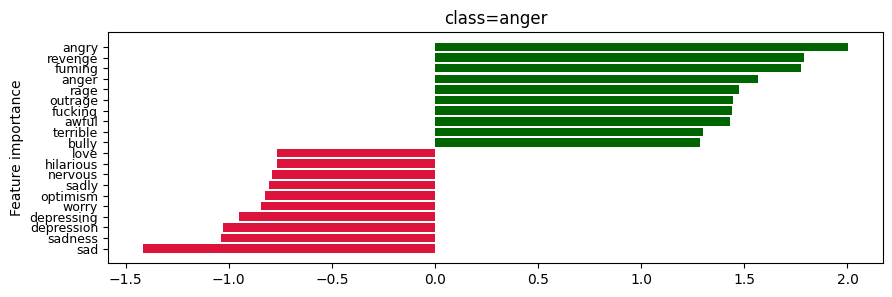

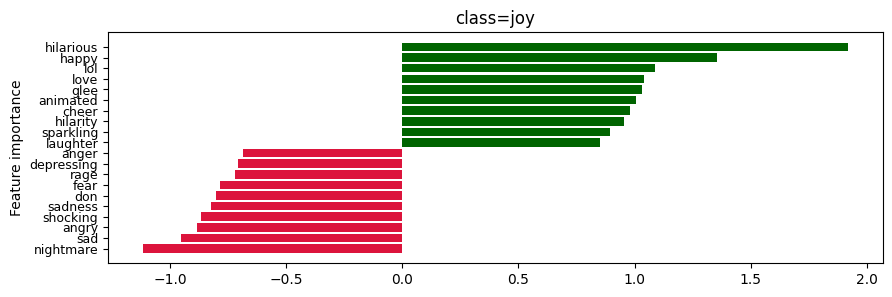

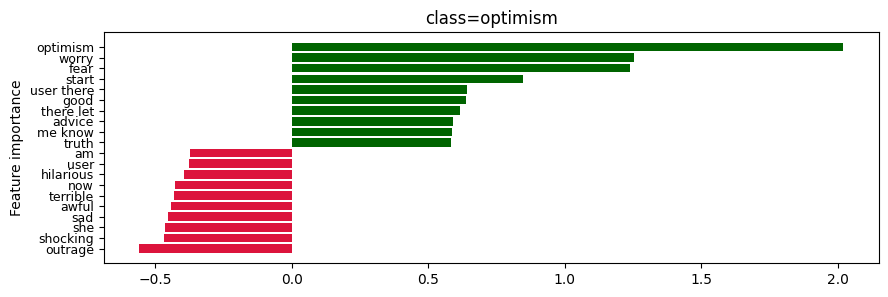

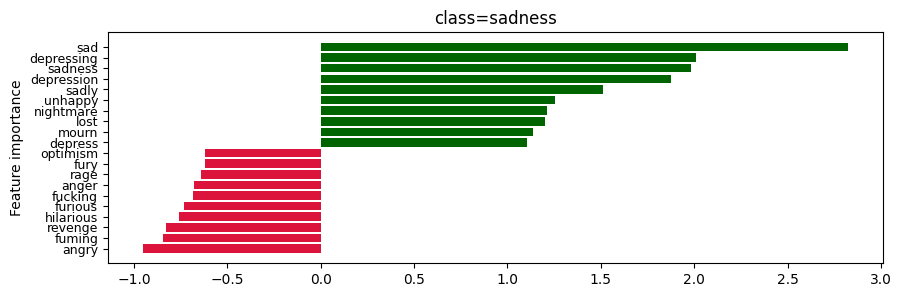

In [43]:
# feature importance
features = best_pipe.named_steps["vectorizer"].get_feature_names_out()
classes = best_pipe.classes_
weights = best_pipe.named_steps["classifier"].coef_ # shape (n_classes, n_features)
# Qué son los weights? Qué significa que sean negativos o positivos?

for i, label in enumerate(classes):
    feat_importance = pd.Series(weights[i], index=features).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.barh(feat_importance.index[:10], feat_importance.values[:10], color="darkgreen")
    ax.barh(feat_importance.index[-10:], feat_importance.values[-10:], color="crimson")
    ax.invert_yaxis()
    plt.title(f"class={label}")
    plt.ylabel("Feature importance")
    plt.yticks(size=9)
    plt.show()


In [44]:
# Evaluacion en test set (OJO, con cuidado! por qué?)

# cuando evaluamos en test podemos entrenar con train+val
X = pd.concat([df_train, df_val]).reset_index(drop=True)["text"]
y = pd.concat([df_train, df_val]).reset_index(drop=True)["label"]
_ = best_pipe.fit(X, y)

              precision    recall  f1-score   support

       anger       0.63      0.86      0.73       558
         joy       0.70      0.56      0.62       358
    optimism       0.48      0.16      0.24       123
     sadness       0.67      0.58      0.63       382

    accuracy                           0.65      1421
   macro avg       0.62      0.54      0.55      1421
weighted avg       0.65      0.65      0.63      1421



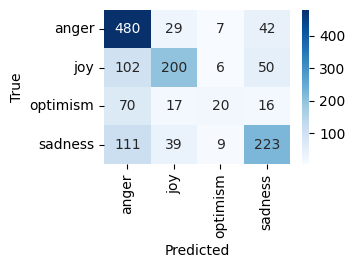

In [45]:
y_pred_test = best_pipe.predict(df_test["text"])

print(classification_report(df_test["label"], y_pred_test))

cm = confusion_matrix(df_test["label"], y_pred_test)
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_pipe.classes_, yticklabels=best_pipe.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Bonus track

¿Cómo agregar otros features?

In [46]:
# Por ejemplo:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

X = pd.concat([df_train, df_val]).reset_index(drop=True)[["text"]]

X["ft_log_n_words"] = X["text"].apply(lambda x: np.log10(len(x.split())))
X["ft_log_n_users"] = np.log10(np.random.randint(1, 1_000, size=len(X))) # por ejemplo
X["ft_has_exclamation"] = X["text"].str.contains("!")
# OJO: acá podemos aplicar transformaciones a todos los datos juntos porque
# son transformaciones que no dependen de la particion train/val/test. Si no
# es así, podemos hacerlo en el pipeline para que no haya "data leakage".

# Esto puede estar un poco desactualizado pero anda,
# con versiones nuevas usar ColumnTransformer
class FeatSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, df, y=None):
        return self
    def transform(self, df):
        return df[self.variables]
    def get_feature_names(self):
        return self.variables

vectorizer = Pipeline([
    ('selector', FeatSelector(variables='text')),
    ('feat_extractor', TfidfVectorizer(min_df=10, max_features=1000, binary=True)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
])
other_features = ['ft_log_n_words', 'ft_log_n_users', 'ft_has_exclamation']

pipe = Pipeline([
    ('features', FeatureUnion([
        ('text', vectorizer),
        ('others', FeatSelector(variables=other_features)), # con "passthrough" podemos excluir este paso
    ])),
    ('scaler', MinMaxScaler()), # Fundamental si usamos regularizacion
    ('clf', LogisticRegression(max_iter=1000, random_state=33)),
])

X_train = X.loc[df_train.index]
y_train = df_train["label"]
X_val = X.loc[df_val.index]

_ = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(fbeta_score(df_val["label"], y_pred, beta=1, average="macro"))

0.26652005312462895


---------------------------------------